In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from source.trainutil import *
from source.datautil import *
from source.model import *
from source.mathutil import *
from tqdm import tqdm_notebook
DEVICE = "cpu" # or "cuda:0"
# torch.cuda.set_device(DEVICE) # uncomment this for CUDA

## Multiple Choice Task

In [3]:
# After first ipython notebook, we'll get an autoencoder doing information map seperation
# and preprocessed json file with information map seperation representations
# In this notbook, we'll going perform the multiple choice task.

In [4]:
PATH_TO_IMAGES_TRAIN = "/storage/hezq17/CLEVR_v1.0/images/train" # change this to where you download the images
data_path_images_train = PATH_TO_IMAGES_TRAIN
PATH_TO_IMAGES_VAL = "/storage/hezq17/CLEVR_v1.0/images/val" # change this to where you download the images
data_path_images_val = PATH_TO_IMAGES_VAL

In [5]:
data_path_json_train = "dataset/json_clevr_train_with_maskautocode_PCM_10p53_h64reg0p5_pgnoise2e-3_focusMode_posiIncld.data"
data_path_json_val = "dataset/json_clevr_val_with_maskautocode_PCM_10p53_h64reg0p5_pgnoise2e-3_focusMode_posiIncld.data"

mulcDataset = MultipleChoiceClevrDataset(data_path_json_train, data_path_images_train, epoch_len = 100000, question_mode="exist_sizecolor")
mulcDataset_val = MultipleChoiceClevrDataset(data_path_json_val, data_path_images_val, epoch_len = 20000, question_mode="exist_sizecolor")

Data load from  dataset/json_clevr_train_with_maskautocode_PCM_10p53_h64reg0p5_pgnoise2e-3_focusMode_posiIncld.data
Parsing dataset ...
Data load from  dataset/json_clevr_val_with_maskautocode_PCM_10p53_h64reg0p5_pgnoise2e-3_focusMode_posiIncld.data
Parsing dataset ...


In [6]:
data_loader = torch.utils.data.DataLoader(
    mulcDataset, batch_size=128, shuffle=True, num_workers=4, collate_fn=mulcDataset.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    mulcDataset_val, batch_size=128, shuffle=True, num_workers=4, collate_fn=mulcDataset_val.collate_fn)

In [7]:
model_para={
    "input_size": 2+8+2+128,
    "input_divide":[2,8,2,128],
    "output_size":8+8+8+16,
    "output_divide":[8,8,8,16],
    "mlp_layer_para": [[16,16],[16,16],[16,16],[32,32]],
    "infobn_model": [{"gs_head_dim":2,"gs_head_num":4},{"gs_head_dim":2,"gs_head_num":4},
                   {"gs_head_dim":2,"gs_head_num":4},{"gs_head_dim":2,"gs_head_num":8}]
}

misc_para={
    "infobn_para":{"temp_scan_num":4,"reg_lamda":0.0,"scale_factor":1.0},
    "sample_mode":False,
    "sample_size":1
}
mltitubeff = Multitube_FF_MLP_CLEVR(model_para, para=misc_para)

In [8]:
model_para_h={
    "input_size": 8+8+8+16, 
    "output_size":1,
    "mlp_layer_para": [32,16,8]
}
model_para_ob={
    "input_size": 10, 
    "output_size":1,
    "mlp_layer_para": [5]
}
# model_para_out={
#     "input_size": 4, 
#     "output_size":4,
#     "mlp_layer_para": [16]
# }
model_para = {
    "HiddenConvFF":model_para_h,
    "ObjConvFF":model_para_ob
#     "OutFF":model_para_out
}
misc_para = {}

convff = ConvFF_MLP_CLEVR(model_para,para=misc_para)

In [9]:
misc_para = {
    "seq1_coop_train_flag": True
}
mltube_convff = ABS_CNN_SEQ(mltitubeff, convff, para=misc_para)

misc_para={
    "loss_flag":"cross_entropy",
    "sample_mode":False,
    "sample_size":1
}
loss = CAL_LOSS(mltube_convff, para = misc_para)

In [10]:
data_dict={"train":data_loader,"val":data_loader_val}
mulcDataset_val.checkmode=False
mulcDataset_val.singlecheckmode=False
run_para={"loss_exp_flag":False, "loss_clip":4}
ptM = PyTrain_Main(loss, data_dict, device=DEVICE, para=run_para)

In [11]:
# First using low reg_lamda helps training
for ii in range(len(mltitubeff.infobnl)):
    mltitubeff.infobnl[ii].reg_lamda=0.0
    mltitubeff.infobnl[ii].scale_factor=1.0

In [12]:
ptM.run_training(epoch=20, lr=1.0e-4, optimizer_label="adam", print_step=200)

In [13]:
num_region = 4
num_dimtot = 20
reg_lamda_scale = num_dimtot/num_region # scale constant between lamda in paper and lamda in code
for ii in range(len(mltitubeff.infobnl)):
    mltitubeff.infobnl[ii].reg_lamda=0.04 * reg_lamda_scale
    mltitubeff.infobnl[ii].scale_factor=1.0

In [14]:
ptM.run_training(epoch=100, lr=1.0e-4, optimizer_label="adam", print_step=200)

In [15]:
load_model(mltube_convff,"pretrained_models/Mltube_Convff_InfoB_PCM_10p53_h64reg0p5_pgnoise2e-3_focusMode_posiIncld_smallyellow.model",
          map_location=DEVICE)

Model load from  pretrained_models/Mltube_Convff_InfoB_PCM_10p53_h64reg0p5_pgnoise2e-3_focusMode_posiIncld_smallyellow.model


ABS_CNN_SEQ(
  (seq1_coop): Multitube_FF_MLP_CLEVR(
    (ff_tubes): ModuleList(
      (0): FF_MLP(
        (linear_layer_stack): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=2, out_features=16, bias=True)
            (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (2): ReLU()
          )
          (1): Sequential(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (2): ReLU()
          )
        )
        (h2o): Linear(in_features=16, out_features=8, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): FF_MLP(
        (linear_layer_stack): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=8, out_features=16, bias=True)
            (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (2): ReLU()
          )
          (1): Sequential(
            (0): Linear(in_features=16

In [16]:
mulcDataset_val.checkmode=False
mulcDataset_val.singlecheckmode=False
ptM.evalmem=None
ptM.mem_eval_mode="task2"
ptM.do_eval(eval_mem_flag=True)

Start evaluation ... 157


157it [00:13, 11.44it/s]

Evaluation Perplexity:  0.01624394078201123
Time used in evaluation:  14.05709958076477


In [17]:
ptM.do_test()

Start testing ...


157it [00:14, 11.20it/s]

Correct rate:  0.99165


0.99165

In [18]:
# Interpretation as meta-information of mutual information flow pattern
evalmatr = np.concatenate(ptM.evalmem[0],axis=0).reshape(-1,40)
evalcontr = np.concatenate(ptM.evalmem[1],axis=0).reshape(-1,40)
evalmat=[]
evalcont=[]
for ii in range(len(evalmatr)):
    if (evalmatr[ii]!=0).any():
        evalmat.append(evalmatr[ii])
        evalcont.append(evalcontr[ii])
evalmat=np.array(evalmat)
evalcont=np.array(evalcont)
print(evalmat.shape, evalcont.shape)

(509900, 40) (509900, 40)


In [19]:
evalmatl=[]
sep=[[0,8],[8,16],[16,24],[24,40]]
lenl=[4,4,4,8]
for ii in range(4):
    evalmatp=evalmat[:,sep[ii][0]:sep[ii][1]].reshape(-1,lenl[ii],2)[:,:,0]
    entp = cal_entropy_raw_ND_discrete(np.round(evalmatp))
    evalmatl.append(entp)
print(evalmatl)

[0.23708420451567547, 0.5253658509953114, 0.23551462188628036, 1.1169105328889426]


In [20]:
evalcontl=[]
for ii in range(4):
    evalcontp=evalcont[:,sep[ii][0]:sep[ii][1]].reshape(-1,2)
    entp = np.mean(cal_entropy(evalcontp,log_flag=True))*lenl[ii]
    evalcontl.append(entp)
print(evalcontl)

[0.23528927504832955, 0.18164258676814177, 0.23498793953784933, 0.4287884571665727]


In [21]:
print("Mutual information flow in each information map:")
print(np.array(evalmatl) - np.array(evalcontl))

Mutual information flow in each information map:
[1.79492947e-03 3.43723264e-01 5.26682348e-04 6.88122076e-01]


## Single Example Explanation

In [22]:
mulcDataset_val.checkmode=True
mulcDataset_val.singlecheckmode=False
datax, Nobjl, ans = mulcDataset_val[int(np.random.rand()*len(mulcDataset_val))]
datax=datax.view(1,4,10,140).expand(16,4,10,140)
print(datax.shape,ans)

Image getting ...
Image getting ...
Image getting ...
Image getting ...
torch.Size([16, 4, 10, 140]) 3


### Dimension by dimension check of GSVIB for each region

In [23]:
outmat = np.concatenate(ptM.evalmem[0],axis=0).reshape(-1,40)
contmat = np.concatenate(ptM.evalmem[1],axis=0).reshape(-1,40)
maskmat = np.concatenate(ptM.evalmem[2],axis=0).reshape(-1)

outmat=outmat[maskmat==1,:]
contmat=contmat[maskmat==1,:]

outmatsub = outmat[:,0:8].reshape(-1,4,2)
contmatsub = contmat[:,0:8].reshape(-1,4,2)
for ii in range(4):
    ent0 = cal_entropy_raw_ND_discrete(np.round(outmatsub[:,ii,:]))
    ent1 = np.mean(cal_entropy(contmatsub[:,ii,:],log_flag=True))
    print(ii, ent0, ent1, "mutual information flow:", ent0-ent1)

0 0.06004513749530355 0.05895072266925102 mutual information flow: 0.0010944148260525269
1 0.05966455220936807 0.05865763204770557 mutual information flow: 0.0010069201616624973
2 0.05734001984383708 0.05735004134670223 mutual information flow: -1.0021502865144305e-05
3 0.06005398043948707 0.060330878984670905 mutual information flow: -0.0002768985451838332


In [24]:
outmat = np.concatenate(ptM.evalmem[0],axis=0).reshape(-1,40)
contmat = np.concatenate(ptM.evalmem[1],axis=0).reshape(-1,40)
maskmat = np.concatenate(ptM.evalmem[2],axis=0).reshape(-1)

outmat=outmat[maskmat==1,:]
contmat=contmat[maskmat==1,:]

outmatsub = outmat[:,8:16].reshape(-1,4,2)
contmatsub= contmat[:,8:16].reshape(-1,4,2)
for ii in range(4):
    ent0 = cal_entropy_raw_ND_discrete(np.round(outmatsub[:,ii,:]))
    ent1 = np.mean(cal_entropy(contmatsub[:,ii,:],log_flag=True))
    print(ii, ent0, ent1,"mutual information flow:",ent0-ent1)

0 0.059185664733317774 0.05883602081390016 mutual information flow: 0.00034964391941761513
1 0.060504498528426945 0.061176023931669675 mutual information flow: -0.0006715254032427301
2 0.3444190609015721 0.0004032642496271082 mutual information flow: 0.344015796651945
3 0.061376413640621436 0.06122727777294488 mutual information flow: 0.00014913586767655723


In [25]:
outmat = np.concatenate(ptM.evalmem[0],axis=0).reshape(-1,40)
contmat = np.concatenate(ptM.evalmem[1],axis=0).reshape(-1,40)
maskmat = np.concatenate(ptM.evalmem[2],axis=0).reshape(-1)

outmat=outmat[maskmat==1,:]
contmat=contmat[maskmat==1,:]

outmatsub = outmat[:,16:24].reshape(-1,4,2)
contmatsub= contmat[:,16:24].reshape(-1,4,2)
for ii in range(4):
    ent0 = cal_entropy_raw_ND_discrete(np.round(outmatsub[:,ii,:]))
    ent1 = np.mean(cal_entropy(contmatsub[:,ii,:],log_flag=True))
    print(ii, ent0, ent1,"mutual information flow:",ent0-ent1)

0 0.057742601925536347 0.05941484546776931 mutual information flow: -0.0016722435422329637
1 0.06298793143570611 0.06144576333462355 mutual information flow: 0.0015421681010825555
2 0.05828711502825765 0.057963106623653844 mutual information flow: 0.0003240084046038025
3 0.05650558650988223 0.056164224111802774 mutual information flow: 0.0003413623980794561


In [26]:
outmat = np.concatenate(ptM.evalmem[0],axis=0).reshape(-1,40)
contmat = np.concatenate(ptM.evalmem[1],axis=0).reshape(-1,40)
maskmat = np.concatenate(ptM.evalmem[2],axis=0).reshape(-1)

outmat=outmat[maskmat==1,:]
contmat=contmat[maskmat==1,:]

outmatsub = outmat[:,24:].reshape(-1,8,2)
contmatsub = contmat[:,24:].reshape(-1,8,2)
for ii in range(8):
    ent0 = cal_entropy_raw_ND_discrete(np.round(outmatsub[:,ii,:]))
    ent1 = np.mean(cal_entropy(contmatsub[:,ii,:],log_flag=True))
    print(ii, ent0, ent1,"mutual information flow:",ent0-ent1)

0 0.6924593461545704 0.005934205881447717 mutual information flow: 0.6865251402731227
1 0.05994784152502615 0.0596539874050433 mutual information flow: 0.0002938541199828462
2 0.05847425083726841 0.05856033412737665 mutual information flow: -8.608329010823673e-05
3 0.059637974974925054 0.06001833413579463 mutual information flow: -0.00038035916086957833
4 0.05701740396608719 0.05543237567531436 mutual information flow: 0.0015850282907728316
5 0.062297448534541194 0.06198230695028866 mutual information flow: 0.0003151415842525332
6 0.059283301495277545 0.05929303167065953 mutual information flow: -9.730175381986172e-06
7 0.06797752898244477 0.06791388132064763 mutual information flow: 6.364766179714487e-05


### Building single explanation matrix

In [27]:
with torch.no_grad():
    yout = mltube_convff((datax.to(DEVICE),Nobjl.to(DEVICE)), schedule=1.0)
singleout = mltube_convff.seq1_coop.output.cpu().numpy()
resmatl=[]
for ii in range(4):
    nobj = int(torch.sum(Nobjl[ii]).item())
    resmat = np.zeros((4,10))
    for iio in range(nobj):
        posiout = singleout[0,ii,iio,8:16]
        headpick_color = 4 # Determine head pick id in last step
        resmat[0,iio]=0
        resmat[1,iio]=posiout[headpick_color]
        resmat[2,iio]=0
        unkout = singleout[0,ii,iio,24:]
        headpick_unknown = 1
        resmat[3,iio]=unkout[headpick_unknown]
    resmatl.append(resmat)

In [28]:
from matplotlib.colors import ListedColormap
seismic = plt.get_cmap('seismic', 11)
newcolors = seismic(np.linspace(0, 1, 11))
grey = np.array([0.8, 0.8, 0.8, 1])
newcolors[0, :] = grey
newcmp = ListedColormap(newcolors)

twocolors = seismic(np.linspace(0, 1, 2))
white = np.array([1, 1, 1, 1])
twocolors[0, :] = white
twocolorsmp = ListedColormap(twocolors)

In [29]:
idpickmat=(mulcDataset_val.mask_tl[0]==1).astype(int)
idpickmat.shape
xlsp = np.linspace(0,479,480)
ylsp = np.linspace(0,319,320)
x = np.sum(idpickmat*xlsp.reshape(1,480))/np.sum(idpickmat)
y = np.sum(idpickmat*ylsp.reshape(320,1))/np.sum(idpickmat)

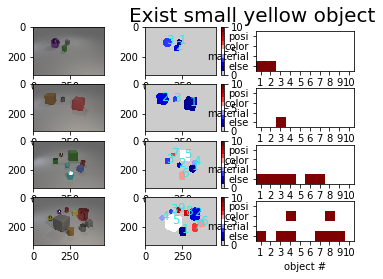

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=3)
for iis in range(4):
    axes[iis][0].imshow(mulcDataset_val.imgl[iis])
    im = axes[iis][1].imshow(mulcDataset_val.mask_tl[iis], cmap=newcmp, clim=(0, 10))
    for iiob in range(1,11): ### Mask labeling
        if (mulcDataset_val.mask_tl[iis]==iiob).any():
            idpickmat=(mulcDataset_val.mask_tl[iis]==iiob).astype(int)
            xlsp = np.linspace(0,479,480)
            ylsp = np.linspace(0,319,320)
            x = np.sum(idpickmat*xlsp.reshape(1,480))/np.sum(idpickmat)
            y = np.sum(idpickmat*ylsp.reshape(320,1))/np.sum(idpickmat)
            if iiob==10:
                shift=20
            else:
                shift=10
            axes[iis][1].text(x-shift,y+10,iiob,fontsize=12,color=[0.2,0.9,0.9])
    fig.colorbar(im, ax=axes[iis][1])
    axes[iis][2].imshow(resmatl[iis], cmap=twocolorsmp, clim=(0, 1))
    axes[iis][2].set_xticks(list(range(10)))
    axes[iis][2].set_xticklabels(list(range(1,11)))
    axes[iis][2].set_yticks(list(range(4)))
    axes[iis][2].set_yticklabels(["posi","color","material","else"])
    axes[iis][2].set_xlabel("object #")
fig.text(0.38, 0.95, "Exist small yellow object", fontsize=20,
        verticalalignment='top')
plt.show()

## Unconceptualized Region Crosscheck via Mutual information

In [31]:
batchcheckmatl=[]
singleoutl=[]
Nobjll=[]

mulcDataset_val.checkmode=False
mulcDataset_val.singlecheckmode=True
data_loader_val = torch.utils.data.DataLoader(
    mulcDataset_val, batch_size=128, shuffle=True, num_workers=4, collate_fn=mulcDataset_val.collate_fn)
for databatch in tqdm_notebook(data_loader_val):
    (datax, Nobjl), answ, batchcheckmat = databatch
    with torch.no_grad():
        yout = mltube_convff((datax.to(DEVICE),Nobjl.to(DEVICE)), schedule=1.0)
    singleout = mltube_convff.seq1_coop.output.cpu()
    contextout = torch.exp(mltube_convff.seq1_coop.contextl.cpu())
    Nobjll.append(Nobjl)
    batchcheckmatl.append(batchcheckmat)
    singleoutl.append(singleout)

Nobjll = torch.cat(Nobjll,dim=0).view(800000)
batchcheckmatl = torch.cat(batchcheckmatl,dim=0).view(800000,4)
singleoutl = torch.cat(singleoutl,dim=0).view(800000,40)

/home/hezq17/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [32]:
colorl = []
sizel = []
color_repl = []
size_repl = []
for ii in tqdm_notebook(range(len(Nobjll))):
    if Nobjll[ii]==1:
        colorl.append(batchcheckmatl[ii,1])
        sizel.append(batchcheckmatl[ii,3])
        color_repl.append(np.round(singleoutl[ii,8:16].numpy()))
        size_repl.append(np.round(singleoutl[ii,24:].numpy()))
colorl=np.array(colorl)
sizel=np.array(sizel)
color_repl = np.array(color_repl)
size_repl = np.array(size_repl)

/home/hezq17/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [33]:
cal_entropy_raw_ND_discrete(colorl)

0.34362705357327306

In [34]:
cal_muinfo_raw_ND_discrete(colorl,color_repl)

0.3369461125507023

In [35]:
cal_entropy_raw_ND_discrete(sizel)

0.692512182057459

In [36]:
cal_muinfo_raw_ND_discrete(sizel,size_repl)

0.6593431584799283